# Random Forests

In this practical we will look at using random forests for a classification task: predicting the outcome of crowdfunded projects on Kickstarter.

# Classification - Predicting Kickstarter Success

`kickstarter_sample.csv` contains a random sample of 5000 Kickstart projects. 

The features are as follows:

| Feature       	| Description                                             	|
|---------------	|---------------------------------------------------------	|
| main_category 	| Major category the project belongs to                   	|
|      category 	| More detailed category label                            	|
|          goal 	| How much money the project wants to raise               	|
|       backers 	| How many people had donated, when time was up           	|
|       country 	| Country the project came from                           	|
|       outcome 	| Whether the project was successful, failed or cancelled 	|

The code below loads in the data then splits it into features (`X`) and labels (`y`).

In [1]:
import pandas as pd

data = pd.read_csv('data/kickstarter_sample.csv')

X = data.drop(['outcome'], axis=1)
y = data['outcome']

In [2]:
data.head()

,category,main_category,goal,outcome,backers,country
0,Photography,Photography,20000.0,failed,1,US
1,Film & Video,Film & Video,200.0,failed,1,NL
2,Webseries,Film & Video,12000.0,failed,19,US
3,Food,Food,20000.0,successful,266,US
4,Art,Art,7500.0,failed,3,US


## Exploring the data

Have a quick look at `data`.

How balanced are the three classes in `state`? (Tip: use `.value_counts()` and specify `normalize=True`)

For each outcome, what was the mean goal? (Tip: use `.groupby()` and then `.mean()` on the relevant column.)

What do the numbers suggest?

In [4]:
# Your code here...


print(data['outcome'].value_counts(normalize=True))

print('Just over half of projects fail. Around 10% are cancelled. Just over a third are successful.\n\n')

print(data.groupby('outcome')['goal'].mean())

print('Successful projects seem to have lower goals.')



outcome
failed        0.5366
successful    0.3628
canceled      0.1006
Name: proportion, dtype: float64
Just over half of projects fail. Around 10% are cancelled. Just over a third are successful.


outcome
canceled      246205.574553
failed         48826.489612
successful     11718.008264
Name: goal, dtype: float64
Successful projects seem to have lower goals.


# Getting the data ready

One issue with the data is that it contains categorical variables - `country`, `category`, and `main_category`. We need to encode these so that they can be used in a machine learning model.

We will use `pandas`'s `get_dummies()` function to one-hot encode the data. Assign the output of `get_dummies()` to `X`.

In [5]:
# Your code here...
X = pd.get_dummies(X)

X.head()

,goal,backers,category_3D Printing,category_Academic,category_Accessories,category_Action,category_Animals,category_Animation,category_Anthologies,category_Apparel,...,country_JP,country_LU,country_MX,"country_N,0""",country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
0,20000.0,1,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,200.0,1,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
2,12000.0,19,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,20000.0,266,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,7500.0,3,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


We will also need to split the data up into training/testing sets - evaluating on the same data we learned from is generally a bad idea.

`sklearn.model_selection` has a function `train_test_split()` which will split up data for us.

Set `random_state=5`, and call the new variables `X_train`, `X_test`, `y_train`, and `y_test`.

In [6]:
# Your code here...
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=5)


# Setting a baseline

Before we move on to using a random forest, it will be useful to know how well a single model performs. This will set a baseline for us to improve upon.

The code below a single Decision Tree model.

Use the `.fit()` and `.score()` methods of the model to train it using the training data and evaluate it on the test set.

In [7]:
from sklearn.tree import DecisionTreeClassifier

In [8]:
dtc_model = DecisionTreeClassifier(random_state=5)

# Your code here...

dtc_model.fit(X_train, y_train)

print(f'Decision Tree single model accuracy: {dtc_model.score(X_test, y_test)}')



Decision Tree single model accuracy: 0.7592


Accuracy only gives us limited information. We have three classes here, so print a confusion matrix for each the decision tree classifier. 

The model is not very good at predicting whether a project will be cancelled (class 0).


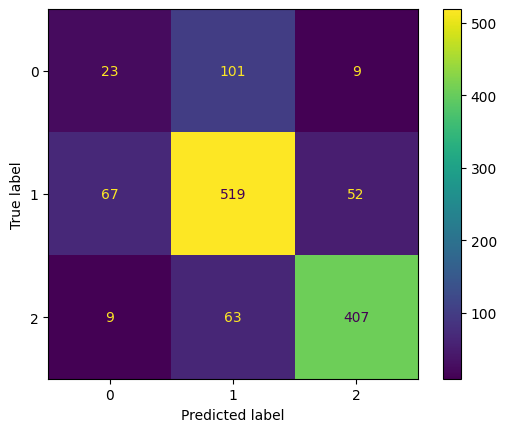

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Your code here...

ConfusionMatrixDisplay(confusion_matrix(y_test, dtc_model.predict(X_test))).plot()

print('The model is not very good at predicting whether a project will be cancelled (class 0).')



# Training a random forest

Training a random forest uses the same steps as above.

Train the model below and get a classification report, as you did for the baseline models.

How does it compare to a single Decision Tree?

Random forest accuracy: 0.7992
Accuracy is higher overall but this is mostly driven by improvements in classifying failed/successful projects - the most common classes.


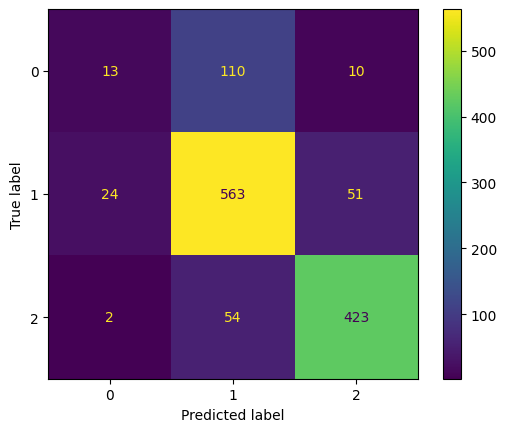

In [10]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=5)

# Your code below

rf.fit(X_train, y_train)

rf_y_pred = rf.predict(X_test)

ConfusionMatrixDisplay(confusion_matrix(y_test, rf_y_pred)).plot()

print(f'Random forest accuracy: {rf.score(X_test, y_test)}')

print('='*53)

print('Accuracy is higher overall but this is mostly driven by improvements in classifying failed/successful projects - the most common classes.')



# Optimising a random forest

So far we have just used the default hyperparameters of the random forest class in `sklearn`: 100 trees, and trees can go as deep as they like.

One convenient way to find the best hyperparameters in `sklearn` is through grid search. This will try all the combinations you request and return the results.

The `GridSearchCV` class takes a model, and a dictionary of hyperparameter and values. Then you just fit/train it as usual, using the training data from before.

We'll try the following:

1. Different depths of the trees - deeper trees can completely overfit to the training data, which can impact generalisability
2. `min_samples_split` and `min_samples_leaf` - hyperparameters for deciding how the decision trees should be built
3. `class_weight` - we can try assigning different weights to the classes, to help with class imbalance
4. `max_samples` - what proportion of the available data each tree should train on
5. `n_estimators` - the number of trees to train

This is 3645 combinations! 

Below, create a `GridSearchCV` in the same way you would a model: assign it to a variable named `gcv`, pass it the `rf` as your basic model and include the parameters we wish to investigate with `param_grid=params`. Fit it to the training data.

To speed things up, set `n_jobs=-1` to use all available CPU cores. Set `verbose=1` so you get updates as it proceeds - useful for making sure it is actually working!

This may take some time...

In [11]:
from sklearn.model_selection import GridSearchCV

params = dict(
    max_depth=[2, 4, 8],
    max_samples=[0.9, 0.75, 0.25],
    n_estimators=[100, 200, 300]
)

rf = RandomForestClassifier(random_state=5, n_jobs=1)

# Your code here...

gcv = GridSearchCV(estimator=rf, param_grid=params, n_jobs=-1, verbose=1)

gcv.fit(X_train, y_train)



Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(estimator=RandomForestClassifier(n_jobs=1, random_state=5),
             n_jobs=-1,
             param_grid={'max_depth': [2, 4, 8],
                         'max_samples': [0.9, 0.75, 0.25],
                         'n_estimators': [100, 200, 300]},
             verbose=1)

# What was the best model?

Note that the `GridSearchCV` evaluated each possible model using the accuracy metric.

The best model is stored inside `gcv` as `best_estimator_`. Its score is in `gcv.best_score_` and the actual hyperparameters used are in `gcv.best_params_`.

Take a look at these and for the best model display the `confusion_matrix` as you did before, using the test set. How does it compare to the non-optimised model?

Best model accuracy: 0.8005333333333333
Best hyperparamters: {'max_depth': 8, 'max_samples': 0.75, 'n_estimators': 300}
Performance on the cancelled class has actually fallen!


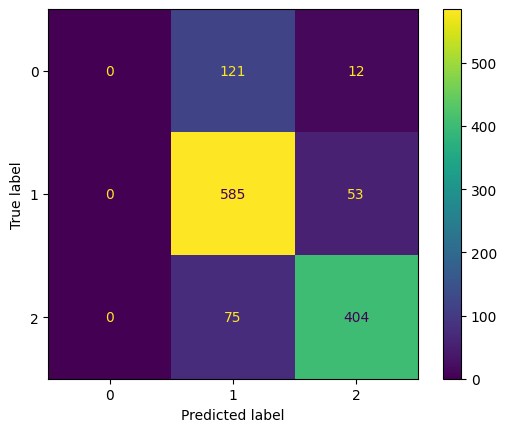

In [12]:
# Your code here...

print(f"Best model accuracy: {gcv.best_score_}")

print(f"Best hyperparamters: {gcv.best_params_}")


best_model = gcv.best_estimator_

y_pred = best_model.predict(X_test)

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

print('='*53)

print('Performance on the cancelled class has actually fallen!')



# Conclusion

The improvements over the baselines were quite good. Fine-tuning the hyperparameters gave only very modest improvements, but this is more likely due to the features used. Think about what kind of features you would ideally have for modeling project funding success/failure. Overall, this illustrates how powerful random forests can be right out of the box.